## Predicting Crime Categories

#### Import statements

In [190]:
import pandas as pd
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report
from seaborn import heatmap
from sklearn import tree

#### Importing train data 

In [191]:
df_train_origin = pd.read_csv("train.csv")
print(df_train_origin.head())
print(len(df_train_origin))

                 Dates        Category                      Descript  \
0  2015-05-13 23:53:00        WARRANTS                WARRANT ARREST   
1  2015-05-13 23:53:00  OTHER OFFENSES      TRAFFIC VIOLATION ARREST   
2  2015-05-13 23:33:00  OTHER OFFENSES      TRAFFIC VIOLATION ARREST   
3  2015-05-13 23:30:00   LARCENY/THEFT  GRAND THEFT FROM LOCKED AUTO   
4  2015-05-13 23:30:00   LARCENY/THEFT  GRAND THEFT FROM LOCKED AUTO   

   DayOfWeek PdDistrict      Resolution                    Address  \
0  Wednesday   NORTHERN  ARREST, BOOKED         OAK ST / LAGUNA ST   
1  Wednesday   NORTHERN  ARREST, BOOKED         OAK ST / LAGUNA ST   
2  Wednesday   NORTHERN  ARREST, BOOKED  VANNESS AV / GREENWICH ST   
3  Wednesday   NORTHERN            NONE   1500 Block of LOMBARD ST   
4  Wednesday       PARK            NONE  100 Block of BRODERICK ST   

            X          Y  
0 -122.425892  37.774599  
1 -122.425892  37.774599  
2 -122.424363  37.800414  
3 -122.426995  37.800873  
4 -122.4387

#### Importing test data 

In [192]:
df_test_origin = pd.read_csv("test.csv")
#print(df_test_origin)

#### Information about the data

In [193]:
df_train_origin.columns

Index(['Dates', 'Category', 'Descript', 'DayOfWeek', 'PdDistrict',
       'Resolution', 'Address', 'X', 'Y'],
      dtype='object')

In [194]:
df_train_origin.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 878049 entries, 0 to 878048
Data columns (total 9 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   Dates       878049 non-null  object 
 1   Category    878049 non-null  object 
 2   Descript    878049 non-null  object 
 3   DayOfWeek   878049 non-null  object 
 4   PdDistrict  878049 non-null  object 
 5   Resolution  878049 non-null  object 
 6   Address     878049 non-null  object 
 7   X           878049 non-null  float64
 8   Y           878049 non-null  float64
dtypes: float64(2), object(7)
memory usage: 60.3+ MB


#### Check whether zero values are contained

In [195]:
df_train_origin.isnull().sum()

Dates         0
Category      0
Descript      0
DayOfWeek     0
PdDistrict    0
Resolution    0
Address       0
X             0
Y             0
dtype: int64

#### Detecting outliers

In [196]:
#GPS of San Francisco
#• Breitengrad von San Francisco:
    #37.7562
#• Längengrad von San Francisco:
    #-122.4430
#• GPS Koordinaten von San Francisco:
    #37° 45‘ 22.32 N 122° 26‘ 34.8 W

coordinates_range = ((df_train_origin.X.min(),   df_train_origin.X.max(),
         df_train_origin.Y.min(), df_train_origin.Y.max()))

print(coordinates_range)

sum = 0
for i in df_train_origin.index:
    if df_train_origin["Y"][i] > 37.9:
        sum +=1
print("sum of Y coordinates outside San Francisco: ", sum)

(-122.51364206429, -120.5, 37.7078790224135, 90.0)
sum of Y coordinates outside San Francisco:  67


#### Check for duplicates

In [197]:
duplicated = df_train_origin[df_train_origin.duplicated()]
len(duplicated)

2323

#### Cleaning data

In [198]:
#remove all records that are not located in San Francisco

df_train_origin = df_train_origin[df_train_origin["Y"] < 38]

df_test_origin = df_test_origin[df_test_origin["Y"] < 38]

#remove duplicated rows!!!
df_train_origin = df_train_origin.drop_duplicates()

#878049
print(len(df_train_origin))

875659


In [199]:
df_train_origin.groupby([df_train_origin['Category']]).size()

Category
ARSON                            1512
ASSAULT                         76811
BAD CHECKS                        406
BRIBERY                           289
BURGLARY                        36599
DISORDERLY CONDUCT               4311
DRIVING UNDER THE INFLUENCE      2268
DRUG/NARCOTIC                   53919
DRUNKENNESS                      4277
EMBEZZLEMENT                     1164
EXTORTION                         256
FAMILY OFFENSES                   488
FORGERY/COUNTERFEITING          10592
FRAUD                           16637
GAMBLING                          146
KIDNAPPING                       2340
LARCENY/THEFT                  174305
LIQUOR LAWS                      1899
LOITERING                        1207
MISSING PERSON                  25669
NON-CRIMINAL                    91911
OTHER OFFENSES                 125943
PORNOGRAPHY/OBSCENE MAT            22
PROSTITUTION                     7446
RECOVERED VEHICLE                3132
ROBBERY                         22987
RUN

#### Mapping of column category (as our "Y")

In [200]:
#all different categories
pd.unique(df_train_origin["Category"])

array(['WARRANTS', 'OTHER OFFENSES', 'LARCENY/THEFT', 'VEHICLE THEFT',
       'VANDALISM', 'NON-CRIMINAL', 'ROBBERY', 'ASSAULT', 'WEAPON LAWS',
       'BURGLARY', 'SUSPICIOUS OCC', 'DRUNKENNESS',
       'FORGERY/COUNTERFEITING', 'DRUG/NARCOTIC', 'STOLEN PROPERTY',
       'SECONDARY CODES', 'TRESPASS', 'MISSING PERSON', 'FRAUD',
       'KIDNAPPING', 'RUNAWAY', 'DRIVING UNDER THE INFLUENCE',
       'SEX OFFENSES FORCIBLE', 'PROSTITUTION', 'DISORDERLY CONDUCT',
       'ARSON', 'FAMILY OFFENSES', 'LIQUOR LAWS', 'BRIBERY',
       'EMBEZZLEMENT', 'SUICIDE', 'LOITERING',
       'SEX OFFENSES NON FORCIBLE', 'EXTORTION', 'GAMBLING', 'BAD CHECKS',
       'TREA', 'RECOVERED VEHICLE', 'PORNOGRAPHY/OBSCENE MAT'],
      dtype=object)

In [35]:
#mapping perhaps better with df.factorize()
'''
dict_category = {}
index = 1
for i in pd.unique(df_train_origin["Category"]):
    val = {i : index}
    dict_category.update(val)
    index+=1

print(dict_category)
'''

'\ndict_category = {}\nindex = 1\nfor i in pd.unique(df_train_origin["Category"]):\n    val = {i : index}\n    dict_category.update(val)\n    index+=1\n\nprint(dict_category)\n'

In [36]:
'''
#mapped column "Category"
Y_df = df_train_origin["Category"].map(dict_category).fillna(df_train_origin["Category"]).astype(int) # categories
'''

'\n#mapped column "Category"\nY_df = df_train_origin["Category"].map(dict_category).fillna(df_train_origin["Category"]).astype(int) # categories\n'

In [201]:
#with factorized
Y_df = pd.factorize(df_train_origin["Category"])
print(Y_df)

(array([ 0,  1,  1, ...,  2,  4, 12], dtype=int64), Index(['WARRANTS', 'OTHER OFFENSES', 'LARCENY/THEFT', 'VEHICLE THEFT',
       'VANDALISM', 'NON-CRIMINAL', 'ROBBERY', 'ASSAULT', 'WEAPON LAWS',
       'BURGLARY', 'SUSPICIOUS OCC', 'DRUNKENNESS', 'FORGERY/COUNTERFEITING',
       'DRUG/NARCOTIC', 'STOLEN PROPERTY', 'SECONDARY CODES', 'TRESPASS',
       'MISSING PERSON', 'FRAUD', 'KIDNAPPING', 'RUNAWAY',
       'DRIVING UNDER THE INFLUENCE', 'SEX OFFENSES FORCIBLE', 'PROSTITUTION',
       'DISORDERLY CONDUCT', 'ARSON', 'FAMILY OFFENSES', 'LIQUOR LAWS',
       'BRIBERY', 'EMBEZZLEMENT', 'SUICIDE', 'LOITERING',
       'SEX OFFENSES NON FORCIBLE', 'EXTORTION', 'GAMBLING', 'BAD CHECKS',
       'TREA', 'RECOVERED VEHICLE', 'PORNOGRAPHY/OBSCENE MAT'],
      dtype='object'))


#### Mapping of column weekday (as a part of "X")

In [152]:
#mapping perhaps better with df.factorize()
'''
#all different weekdays
pd.unique(df_train_origin["DayOfWeek"])
'''

'\n#all different weekdays\npd.unique(df_train_origin["DayOfWeek"])\n'

In [40]:
'''
#dict weekday
dict_weekday = {"Monday" : 1, "Tuesday" : 2, "Wednesday" : 3, "Thursday" : 4, "Friday" : 5, "Saturday" : 6, "Sunday" : 7 }
print(dict_weekday)
'''

'\n#dict weekday\ndict_weekday = {"Monday" : 1, "Tuesday" : 2, "Wednesday" : 3, "Thursday" : 4, "Friday" : 5, "Saturday" : 6, "Sunday" : 7 }\nprint(dict_weekday)\n'

In [39]:
'''
#mapped column "DayOfWeek"
weekdays = df_train_origin["DayOfWeek"].map(dict_weekday).fillna(df_train_origin["DayOfWeek"]).astype(int)
'''

'\n#maped column "DayOfWeek"\nweekdays = df_train_origin["DayOfWeek"].map(dict_weekday).fillna(df_train_origin["DayOfWeek"]).astype(int)\n'

In [202]:
#with factorize
weekdays = pd.factorize(df_train_origin["DayOfWeek"])

#### Mapping of column PdDistrict (as a part of "X")

In [42]:
#mapping perhaps better with df.factorize()
'''
#all different police department district
pd.unique(df_train_origin["PdDistrict"])
'''

'\n#all different police department district\npd.unique(df_train_origin["PdDistrict"])\n'

In [43]:
'''
dict_PdDistrict = {}
index = 1
for i in pd.unique(df_train_origin["PdDistrict"]):
    val = {i : index}
    dict_PdDistrict.update(val)
    index+=1

print(dict_PdDistrict)
'''

'\ndict_PdDistrict = {}\nindex = 1\nfor i in pd.unique(df_train_origin["PdDistrict"]):\n    val = {i : index}\n    dict_PdDistrict.update(val)\n    index+=1\n\nprint(dict_PdDistrict)\n'

In [144]:
'''
#mapped column "Category"
pdDistricts = df_train_origin["PdDistrict"].map(dict_PdDistrict).fillna(df_train_origin["PdDistrict"]).astype(int)
'''

In [203]:
#with factorize
pdDistricts = pd.factorize(df_train_origin["PdDistrict"])

#### Mapping of all addresses (as a part of "X", perhaps not e part of X)

In [204]:
#mapping perhaps better with df.factorize()

#all different Addresses -> to cluster!!!
adress = pd.unique(df_train_origin["Address"])
for a in adress:
    print(a)


OAK ST / LAGUNA ST
VANNESS AV / GREENWICH ST
1500 Block of LOMBARD ST
100 Block of BRODERICK ST
0 Block of TEDDY AV
AVALON AV / PERU AV
KIRKWOOD AV / DONAHUE ST
600 Block of 47TH AV
JEFFERSON ST / LEAVENWORTH ST
0 Block of ESCOLTA WY
TURK ST / JONES ST
FILLMORE ST / GEARY BL
200 Block of WILLIAMS AV
0 Block of MENDELL ST
EDDY ST / JONES ST
GODEUS ST / MISSION ST
MENDELL ST / HUDSON AV
100 Block of JONES ST
200 Block of EVELYN WY
1600 Block of VALENCIA ST
FILLMORE ST / LOMBARD ST
300 Block of OFARRELL ST
2000 Block of BUSH ST
500 Block of COLLEGE AV
19TH AV / SANTIAGO ST
2000 Block of 41ST AV
1300 Block of WEBSTER ST
400 Block of CASTRO ST
1500 Block of FILLMORE ST
1600 Block of WEBSTER ST
KING ST / 3RD ST
VALLEJO ST / BUCHANAN ST
CALIFORNIA ST / BUCHANAN ST
1400 Block of HOLLOWAY AV
0 Block of WINDING WY
700 Block of MARKET ST
1600 Block of MARKET ST
0 Block of STOCKTON ST
300 Block of WILLIAMS AV
800 Block of LEAVENWORTH ST
0 Block of CRESCENT AV
LINCOLN WY / 14TH AV
SUTTER ST / POWEL

MARKET ST / POWELL ST
1000 Block of HARRISON ST
1400 Block of 27TH AV
0 Block of RICO WY
GOLDEN GATE AV / JONES ST
700 Block of TARAVAL ST
2700 Block of CLAY ST
1200 Block of GENEVA AV
1600 Block of QUESADA AV
400 Block of DETROIT ST
18TH ST / SOUTH VAN NESS AV
100 Block of HALE ST
UNION ST / GOUGH ST
6300 Block of GEARY BL
2400 Block of 23RD ST
1400 Block of PINE ST
3900 Block of GEARY BL
NEWCOMB AV / NEWHALL ST
19TH ST / MINNESOTA ST
3900 Block of 18TH ST
300 Block of PAGE ST
3RD AV / CABRILLO ST
DUBOCE AV / GUERRERO ST
2200 Block of 14TH AV
500 Block of COLUMBUS AV
1600 Block of MISSION ST
1900 Block of VANNESS AV
0 Block of CHUMASERO DR
300 Block of WINDING WY
1300 Block of UTAH ST
JOHNFSHELLEY DR / CAMBRIDGE ST
BUSH ST / FRANKLIN ST
SAN BRUNO AV / FELTON ST
600 Block of TAYLOR ST
2500 Block of 34TH AV
MARTIN LUTHER KING JR DR / CROSSOVER DR
0 Block of SOUTHPARK AV
OFARRELL ST / SCOTT ST
900 Block of MONTEREY BL
1700 Block of ELLIS ST
700 Block of HEAD ST
EDDY ST / HYDE ST
MCALLIST

FRANCISCO ST / COLUMBUS AV
LOMITA AV / ALOHA AV
1900 Block of QUESADA AV
400 Block of COLUMBUS AV
200 Block of CLAY ST
GOLDEN GATE AV / TAYLOR ST
1300 Block of ILLINOIS ST
1200 Block of INGALLS ST
3000 Block of PINE ST
33RD AV / NORIEGA ST
CLAY ST / VANNESS AV
2700 Block of FOLSOM ST
700 Block of POTRERO AV
12TH ST / HARRISON ST
STEVENSON ST / 6TH ST
1400 Block of FELL ST
500 Block of COLE ST
0 Block of 26TH AV
CALIFORNIA ST / FRONT ST
600 Block of 37TH AV
200 Block of NOE ST
300 Block of 18TH AV
0 Block of 8TH ST
SAN JOSE AV / RANDALL ST
MARIPOSA ST / BRYANT ST
500 Block of DARIEN WY
SLOAT BL / 36TH AV
1200 Block of WISCONSIN ST
500 Block of 2ND ST
0 Block of AVERY ST
2000 Block of SACRAMENTO ST
100 Block of COSO AV
VANNESS AV / WASHINGTON ST
MISSION ST / RANDALL ST
800 Block of JAMESTOWN AV
400 Block of CLAYTON ST
1000 Block of FRANKLIN ST
0 Block of SAINT FRANCIS BL
BOWDOIN ST / BURROWS ST
PARKPRESIDIO BL / CROSSOVER DR
2100 Block of JENNINGS ST
3600 Block of CALIFORNIA ST
1100 Bloc

WOOLSEY ST / HAMILTON ST
400 Block of 11TH ST
NOE ST / HENRY ST
LAGUNA ST / WILLOW ST
HOLLOWAY AV / GRANADA AV
ORTEGA ST / 20TH AV
1900 Block of BAKER ST
BAKER ST / GREENWICH ST
100 Block of SHAWNEE AV
STEINER ST / TURK ST
700 Block of PRAGUE ST
HENRYADAMS ST / ALAMEDA ST
2000 Block of 32ND AV
PHELPS ST / GALVEZ AV
JENNINGS ST / FITZGERALD AV
BOWDOIN ST / OLMSTEAD ST
0 Block of BRADFORD ST
LEAVENWORTH ST / SUTTER ST
BAY ST / LEAVENWORTH ST
25TH AV / FULTON ST
PINE ST / LAGUNA ST
2200 Block of LANE ST
FRANCISCO ST / TAYLOR ST
200 Block of PAUL AV
3300 Block of SCOTT ST
800 Block of WISCONSIN ST
300 Block of 9TH AV
800 Block of NORTHPOINT ST
SCOTT ST / BUSH ST
QUINTARA ST / 20TH AV
0 Block of GLADSTONE DR
11TH ST / MINNA ST
BAY ST / WEBSTER ST
LINCOLN WY / 5TH AV
MIGUEL ST / ARLINGTON ST
BAY SHORE BL / WHEAT ST
3600 Block of TARAVAL ST
3RD AV / LAKE ST
FILLMORE ST / DUBOCE AV
JUNIPERO SERRA BL / 19TH AV
CONRAD ST / ARBOR ST
SUTTER ST / GOUGH ST
CESAR CHAVEZ ST / INDIANA ST
43RD AV / SLOA

FOLSOM ST / CESAR CHAVEZ ST
ANZA ST / 35TH AV
FOLSOM ST / COLUMBIASQUARE ST
200 Block of ASHTON AV
CHENERY ST / DIAMOND ST
RICHARDSON AV / LYON ST
22ND AV / GEARY BL
700 Block of FRANCISCO ST
100 Block of NORIEGA ST
BAKER ST / MCALLISTER ST
3600 Block of WEBSTER ST
2100 Block of CARROLL AV
10TH AV / CLEMENT ST
16TH ST / HOFF ST
100 Block of WILLIAMS AV
200 Block of ARGUELLO BL
HOWARD ST / FREMONT ST
100 Block of WHITTIER ST
100 Block of MERCED AV
16TH ST / JULIAN AV
VANNESS AV / SOUTH VAN NESS AV
100 Block of CLINTONPARK ST
FILBERT ST / LEAVENWORTH ST
CORTLAND AV / BENNINGTON ST
1700 Block of KEARNY ST
0 Block of TARAVAL ST
PHELAN AV / OCEAN AV
1500 Block of BRODERICK ST
JUSTIN DR / ALEMANY BL
1400 Block of MISSION ST
RUSSIA AV / LONDON ST
WATERVILLE ST / THORNTON AV
FOLSOM ST / 19TH ST
GRANT AV / COLUMBUS AV
300 Block of SANLEANDRO WY
200 Block of 5TH ST
ALEMANY BL / CRYSTAL ST
1800 Block of BRODERICK ST
100 Block of 9TH AV
WASHINGTON ST / STOCKTON ST
PHELPS ST / LASALLE AV
CHUMASERO 

700 Block of ANDOVER ST
LASALLE AV / GARLINGTON CT
PACIFIC AV / OCTAVIA ST
DANIELBURNHAM CT / FRANKLIN ST
2900 Block of YORBA ST
1200 Block of JUDAH ST
4100 Block of FULTON ST
GEARY BL / 47TH AV
1600 Block of REVERE AV
400 Block of 22ND ST
GREENWICH ST / WEBSTER ST
600 Block of LINCOLN WY
MISSION ST / GRACE ST
26TH ST / KANSAS ST
EXCELSIOR AV / MOSCOW ST
DORLAND ST / DOLORES ST
4900 Block of ANZA ST
600 Block of ITALY AV
FUNSTON AV / QUINTARA ST
100 Block of ALPINE TR
1600 Block of 28TH AV
2500 Block of HAWES ST
1100 Block of SILVER AV
KEARNY ST / FRESNO ST
CLAREMONT BL / KENSINGTON WY
100 Block of MARINA BL
200 Block of DELANO AV
GRANT AV / UNION ST
2400 Block of FUNSTON AV
ALEMANY BL / HARRINGTON ST
0 Block of ROTTECK ST
900 Block of MENDELL ST
500 Block of UNIVERSITY ST
UNION ST / VANNESS AV
1100 Block of OAK ST
VALENCIA ST / 20TH ST
700 Block of MINNESOTA ST
2600 Block of ELCAMINODELMAR ST
0 Block of ROBINSON DR
2600 Block of 40TH AV
0 Block of KISSLING ST
FARRAGUT AV / ALEMANY BL


1300 Block of 26TH AV
200 Block of ARLINGTON ST
0 Block of BRUMISS TR
300 Block of WAWONA ST
800 Block of JOHNFKENNEDY DR
300 Block of STANYAN ST
PORTOLA DR / TERESITA BL
BELVEDERE ST / GRATTAN ST
2000 Block of 42ND AV
WILLIAMS AV / LUCY ST
CASTRO ST / 21ST ST
24TH ST / RHODEISLAND ST
HARKNESS AV / BRUSSELS ST
1800 Block of GROVE ST
45TH AV / PACHECO ST
RUSSIA AV / MADRID ST
TUCKER AV / RUTLAND ST
1000 Block of JACKSON ST
FULTON ST / 36TH AV
0 Block of OAK ST
GREEN ST / VARENNES ST
3100 Block of LAGUNA ST
IRVING ST / 2ND AV
BLAKE ST / GEARY BL
0 Block of ZAMPA LN
HAYES ST / SHRADER ST
GOLDEN GATE AV / SCOTT ST
800 Block of LISBON ST
ILLINOIS ST / 25TH ST
1200 Block of JOHNFKENNEDY DR
GREAT HWY / TARAVAL ST
1700 Block of ALABAMA ST
ELLIS ST / BEIDEMAN ST
LINCOLN WY / 38TH AV
600 Block of LISBON ST
JOHNFKENNEDY DR / 36TH AV
GREAT HWY / VICENTE ST
1400 Block of JOHNFKENNEDY DR
200 Block of DUBOCE AV
FULTON ST / 31ST AV
LONDON ST / GENEVA AV
LEE AV / OCEAN AV
HARRISON ST / ALAMEDA ST
JUNIP

0 Block of ARLETA AV
500 Block of VISITACION AV
2100 Block of LINCOLN WY
1900 Block of STOCKTON ST
DOLORES ST / 25TH ST
GONZALEZ DR / FONT BL
DUNCAN ST / SAN JOSE AV
HURON AV / SICKLES AV
200 Block of GAMBIER ST
200 Block of ORDWAY ST
PRESIDIO AV / CLAY ST
HARRISON ST / FREMONT ST
100 Block of BOWDOIN ST
600 Block of LAKE ST
2100 Block of THOMAS AV
600 Block of PALMETTO AV
800 Block of AVALON AV
2700 Block of HAWES ST
OSHAUGHNESSY BL / BOSWORTH ST
NORIEGA ST / 28TH AV
700 Block of MADRID ST
0 Block of NEPTUNE ST
24TH ST / DOUGLASS ST
CORTLAND AV / PERALTA AV
PERU AV / ATHENS ST
BRODERICK ST / BAY ST
1400 Block of 43RD AV
100 Block of LUCKY ST
0 Block of DASHIELL HAMMETT ST
WISCONSIN ST / 16TH ST
OAKDALE AV / INGALLS ST
TURK ST / TAMALPAIS TR
800 Block of 41ST AV
BRODERICK ST / EDDY ST
800 Block of EDINBURGH ST
300 Block of CAMBRIDGE ST
BRODERICK ST / HAIGHT ST
0 Block of JUNIOR TR
2400 Block of 31ST AV
HOWTH ST / MOUNT VERNON AV
400 Block of MAGELLAN AV
200 Block of BRADFORD ST
ERIE ST

VALLEY ST / SAN JOSE AV
JUDAH ST / 19TH AV
1200 Block of SILLIMAN ST
RUTLAND ST / TEDDY AV
GROVE ST / BRODERICK ST
MERCHANT ST / SANSOME ST
3700 Block of BRODERICK ST
200 Block of MONTCALM ST
100 Block of RICHARDSON AV
STATES ST / LEVANT ST
600 Block of EUGENIA AV
4100 Block of 20TH ST
LASALLE AV / PHELPS ST
OCEAN AV / KEYSTONE WY
1300 Block of 32ND AV
1600 Block of BAY SHORE BL
EUGENIA AV / ELSIE ST
HUDSON AV / INGALLS ST
AVALON AV / MADRID ST
3400 Block of RIVERA ST
PHELAN AV / STAPLES AV
MOSCOW ST / EXCELSIOR AV
10TH AV / MENDOSA AV
CHESTNUT ST / LARKIN ST
CHURCH ST / 25TH ST
2600 Block of YORBA ST
BEACON ST / HARRY ST
LECONTE AV / KEITH ST
2ND AV / HUGO ST
DUNCAN ST / CHURCH ST
0 Block of DIGBY ST
0 Block of SANANSELMO AV
CLAY ST / LAGUNA ST
0 Block of HEMWAY TR
44TH AV / ULLOA ST
2400 Block of CASTRO ST
LELAND AV / BAY SHORE BL
GREEN ST / MASON ST
0 Block of SHELDON TR
IRVING ST / 45TH AV
PAGE ST / PIERCE ST
DORLAND ST / CHURCH ST
1900 Block of 32ND AV
1500 Block of ELLIS ST
GOUGH

200 Block of NORTHRIDGE DR
0 Block of DEWOLF ST
REGENT ST / CAYUGA AV
4200 Block of LAWTON ST
VISITACION AV / TALBERT CT
2000 Block of LANE ST
12TH ST / BERNICE ST
FILLMORE ST / MARINA BL
TOLAND ST / NAPOLEON ST
21ST AV / ANZA ST
600 Block of BUCHANAN ST
26TH ST / BRYANT ST
POLLARD PL / VALLEJO ST
ALMA ST / COLE ST
FILLMORE ST / BROADWAY ST
500 Block of 25TH ST
26TH ST / ORANGE ST
1100 Block of FRONT ST
LANE ST / YOSEMITE AV
0 Block of GOLETA AV
SANCHEZ ST / 24TH ST
SANTACLARA AV / YERBABUENA AV
ASHTON AV / LEGION CT
300 Block of PRENTISS ST
900 Block of MASONIC AV
SANTIAGO ST / 20TH AV
SCOTIA AV / QUINT ST
DEHARO ST / 24TH ST
OTSEGO AV / SANTAYSABEL AV
ATALAYA TR / FULTON ST
400 Block of JERSEY ST
0 Block of MEDAU PL
PIERCE ST / CALIFORNIA ST
PHELPS ST / BACON ST
POWELL ST / THE EMBARCADERONORTH ST
BENTON AV / BACHE ST
DIAMOND ST / 28TH ST
1000 Block of VICENTE ST
GARFIELD ST / VERNON ST
LENOX WY / TARAVAL ST
EUCALYPTUS DR / OCEAN AV
100 Block of ELK ST
0 Block of PRESIDIO AV
RANDALL 

SANTIAGO ST / 32ND AV
BURNETT AV / CRESTLINE DR
ITALY AV / NAPLES ST
16TH ST / SHARON ST
LEE AV / GRAFTON AV
CORBETT AV / DOUGLASS ST
VICTORIA ST / RANDOLPH ST
NORIEGA ST / 46TH AV
DAVIS ST / PINE ST
100 Block of JOHNSTONE DR
CARROLL AV / NEWHALL ST
HEATHER AV / EUCLID AV
23RD AV / QUINTARA ST
LAUREL ST / LUPINE AV
42ND AV / IRVING ST
JOHN ST / POWELL ST
KIRKHAM ST / 6TH AV
200 Block of ESMERALDA AV
1200 Block of 16TH ST
VALERTON CT / CAYUGA AV
VISITACION AV / DELTA ST
GRANDVIEW AV / 24TH ST
300 Block of LATHROP AV
4TH AV / LINCOLN WY
THORNTON AV / DIANA ST
FRESNO ST / KEARNY ST
1500 Block of GREAT HWY
WOOL ST / EUGENIA AV
CHAPMAN ST / NEVADA ST
100 Block of GARCIA AV
OGDEN AV / GATES ST
2500 Block of 19TH AV
EDNA ST / FLOOD AV
1900 Block of INNES AV
SANANSELMO AV / PORTOLA DR
CLIFFORD TR / ASHBURY ST
GELLERT DR / CLEARFIELD DR
BANCROFT AV / PHELPS ST
JANSEN ST / GREENWICH ST
16TH AV / VICENTE ST
HAWES ST / INGERSON AV
18TH AV / SANTIAGO ST
PRINCETON ST / SILLIMAN ST
GREAT HWY / SLOAT 

JUANBAUTISTA CR / JOSEPHA AV
44TH AV / SANTIAGO ST
DIAMOND ST / ALVARADO ST
3900 Block of MARKET ST
ELLERT ST / ANDOVER ST
WAWONA ST / 14TH AV
PACIFIC AV / TRENTON ST
38TH AV / RIVERA ST
LAWRENCE AV / ALEMANY BL
38TH AV / IRVING ST
RIVERA ST / 25TH AV
WOOD ST / LUPINE AV
MARIPOSA ST / YORK ST
VESTA ST / WILLIAMS AV
FOOTE AV / ELLINGTON AV
EDWARD ST / WILLARDNORTH ST
44TH AV / QUINTARA ST
DELANO AV / SEMINOLE AV
KEITH ST / SALINAS AV
2300 Block of 22ND ST
2100 Block of GREAT HWY
QUINTARA ST / 27TH AV
28TH ST / GUERRERO ST
CLAREMONT BL / DORCHESTER WY
WALLER ST / CASTRO ST
PASADENA ST / GENEVA AV
ELIZABETH ST / HOFFMAN AV
30TH AV / RIVERA ST
GEARY BL / JORDAN AV
2400 Block of 19TH ST
BRYANT ST / DECATUR ST
JONES ST / MACONDRAY ST
0 Block of GRANVILLE WY
MAYNARD ST / MISSION ST
28TH AV / ULLOA ST
PERU AV / NAPLES ST
CHENERY ST / CARRIE ST
LOWELL ST / BRUNSWICK ST
ELLINGTON AV / WHIPPLE AV
GUTTENBERG ST / MORSE ST
OTTAWA AV / DELANO AV
PEMBERTON PL / GRAYSTONE TR
0 Block of 7THSTNORTH ST
S

In [205]:
#print(df_train_origin["Address"][::][-3:])
addresses_short = []
for address in df_train_origin["Address"]:
    addresses_short.append(address[-3:])
    
addresses_short = pd.DataFrame (addresses_short, columns = ['Addresses_short'])
addresses_short.columns

Index(['Addresses_short'], dtype='object')

In [137]:
'''
dict_Addresses = {}
index = 1
for i in pd.unique(df_train_origin["Address"]):
    val = {i : index}
    dict_Addresses.update(val)
    index+=1

#print(dict_Addresses)
'''

'\ndict_Addresses = {}\nindex = 1\nfor i in pd.unique(df_train_origin["Address"]):\n    val = {i : index}\n    dict_Addresses.update(val)\n    index+=1\n\n#print(dict_Addresses)\n'

In [206]:
'''
#maped column "Addresses"
addresses = df_train_origin["Address"].map(dict_Addresses).fillna(df_train_origin["Address"]).astype(int)
'''

'\n#maped column "Addresses"\naddresses = df_train_origin["Address"].map(dict_Addresses).fillna(df_train_origin["Address"]).astype(int)\n'

In [207]:
#with factorize
addresses = pd.factorize(addresses_short["Addresses_short"])
addresses

(array([0, 0, 0, ..., 0, 0, 1], dtype=int64),
 Index([' ST', ' AV', ' WY', ' BL', ' DR', ' CT', ' TR', ' HY', ' RD', ' PZ',
        ' PL', ' LN', 'WAY', ' AL', ' CR', 'LMS', 'TER', 'TWY', 'HWY', 'TTI',
        ' WK', ' EX', ' RW', 'ANO', 'MAR', '-80', 'ARK', '280', 'T /', 'V /'],
       dtype='object'))

#### Mapping of days are in weekend

In [208]:
weekends = (df_train_origin["DayOfWeek"]== "Sunday" ) | (df_train_origin["DayOfWeek"] == "Saturday")
weekends = weekends.replace(False, 0)
weekends = weekends.replace(True, 1)

#### Converting Dates to timestamps (it is split into individual attributes for meaningful use)

In [209]:
datetimes =  pd.to_datetime(df_train_origin['Dates'])
datetimes

0        2015-05-13 23:53:00
1        2015-05-13 23:53:00
2        2015-05-13 23:33:00
3        2015-05-13 23:30:00
4        2015-05-13 23:30:00
                 ...        
878044   2003-01-06 00:15:00
878045   2003-01-06 00:01:00
878046   2003-01-06 00:01:00
878047   2003-01-06 00:01:00
878048   2003-01-06 00:01:00
Name: Dates, Length: 875659, dtype: datetime64[ns]

#### Generating mapped dataFrame (as our "X)

In [210]:
data_new = { "DayOfWeek": weekdays[0], "Weekend": weekends,
            "PdDistrict": pdDistricts[0], "Address": addresses[0],
            "X": df_train_origin["X"], "Y":df_train_origin["Y"] }
#"Resolution" : resolutions, "Descript": descriptions,

In [211]:
X_df = pd.DataFrame(data_new)
print(X_df)

        DayOfWeek  Weekend  PdDistrict  Address           X          Y
0               0        0           0        0 -122.425892  37.774599
1               0        0           0        0 -122.425892  37.774599
2               0        0           0        0 -122.424363  37.800414
3               0        0           0        0 -122.426995  37.800873
4               0        0           1        0 -122.438738  37.771541
...           ...      ...         ...      ...         ...        ...
878044          2        0           6        1 -122.459033  37.714056
878045          2        0           2        0 -122.447364  37.731948
878046          2        0           9        0 -122.403390  37.780266
878047          2        0           9        0 -122.390531  37.780607
878048          2        0           3        1 -122.394926  37.738212

[875659 rows x 6 columns]


In [212]:
#splitting dates in different time features
#L = ['year', 'month', 'day', 'dayofyear', 'week', 'quarter', 'hour']
L = ['year', 'month', 'quarter', 'hour']
print(L)
date_gen = (getattr(datetimes.dt, i).rename(i) for i in L)
print(date_gen)
print(X_df.columns)
X_df = X_df.join(pd.concat(date_gen, axis=1))

print(X_df)

['year', 'month', 'quarter', 'hour']
<generator object <genexpr> at 0x00000206BAEAC4A0>
Index(['DayOfWeek', 'Weekend', 'PdDistrict', 'Address', 'X', 'Y'], dtype='object')
        DayOfWeek  Weekend  PdDistrict  Address           X          Y  year  \
0               0        0           0        0 -122.425892  37.774599  2015   
1               0        0           0        0 -122.425892  37.774599  2015   
2               0        0           0        0 -122.424363  37.800414  2015   
3               0        0           0        0 -122.426995  37.800873  2015   
4               0        0           1        0 -122.438738  37.771541  2015   
...           ...      ...         ...      ...         ...        ...   ...   
878044          2        0           6        1 -122.459033  37.714056  2003   
878045          2        0           2        0 -122.447364  37.731948  2003   
878046          2        0           9        0 -122.403390  37.780266  2003   
878047          2        0   

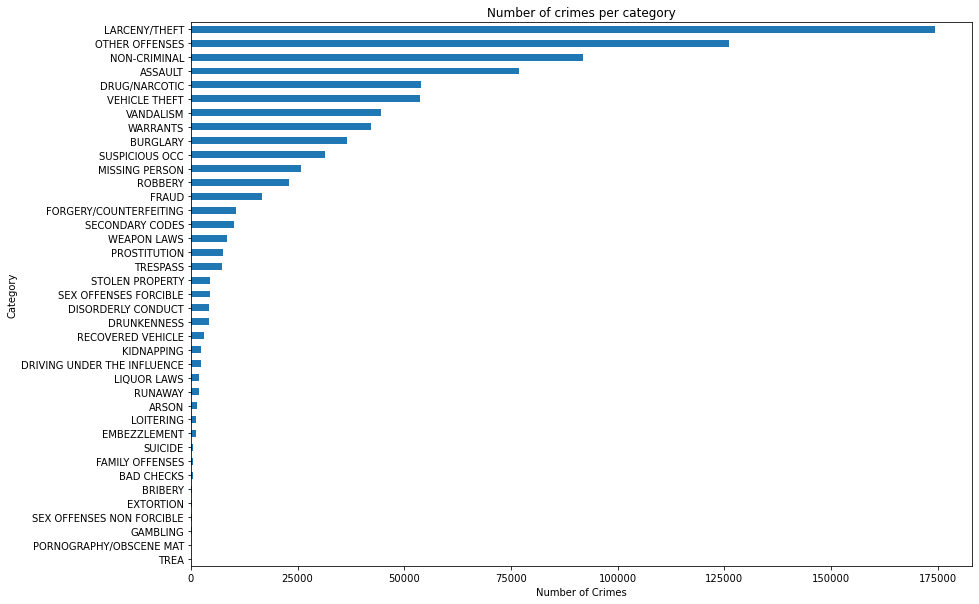

In [213]:
plt.figure(figsize=(14,10))
plt.title('Number of crimes per category')
plt.ylabel('Category')
plt.xlabel('Number of Crimes')


X_df.groupby([df_train_origin['Category']]).size().sort_values(ascending=True).plot(kind='barh')

plt.show()

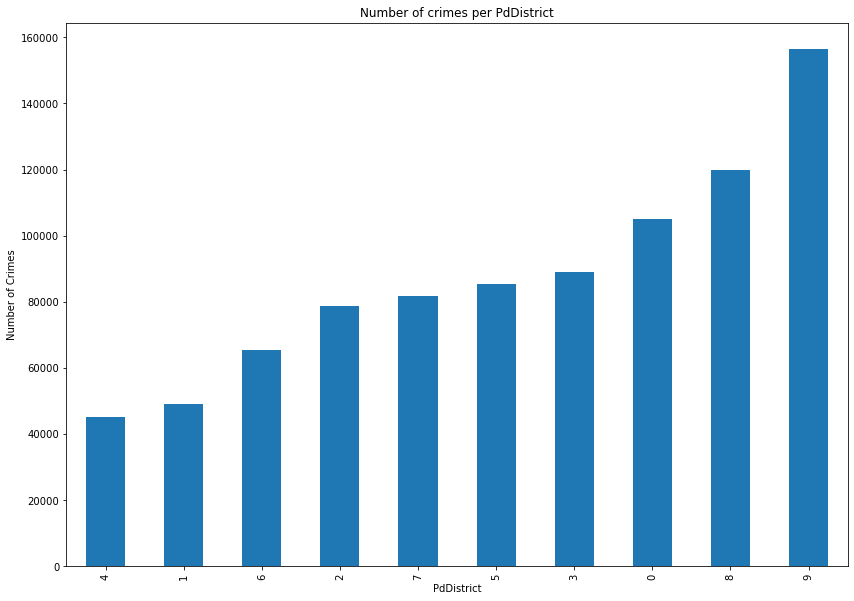

In [214]:
#Crimes per PdDistrict

plt.figure(2, figsize=(14,10))
plt.title('Number of crimes per PdDistrict')
plt.ylabel('Number of Crimes')
plt.xlabel('PdDistrict')


X_df.groupby([X_df['PdDistrict']]).size().sort_values(ascending=True).plot(kind='bar')

plt.show()

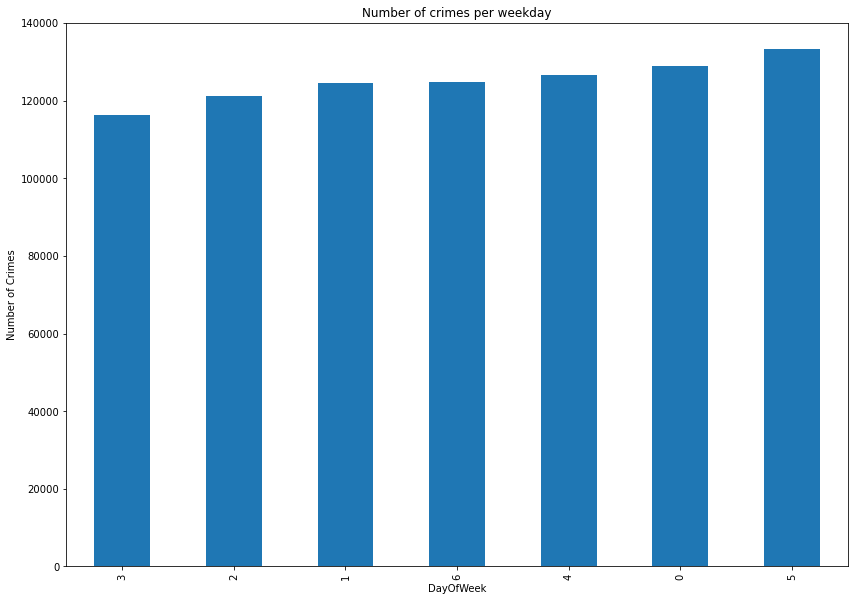

In [215]:
#Crimes per hour

plt.figure(3, figsize=(14,10))
plt.title('Number of crimes per weekday')
plt.ylabel('Number of Crimes')
plt.xlabel('weekday')


X_df.groupby([X_df['DayOfWeek']]).size().sort_values(ascending=True).plot(kind='bar')

plt.show()

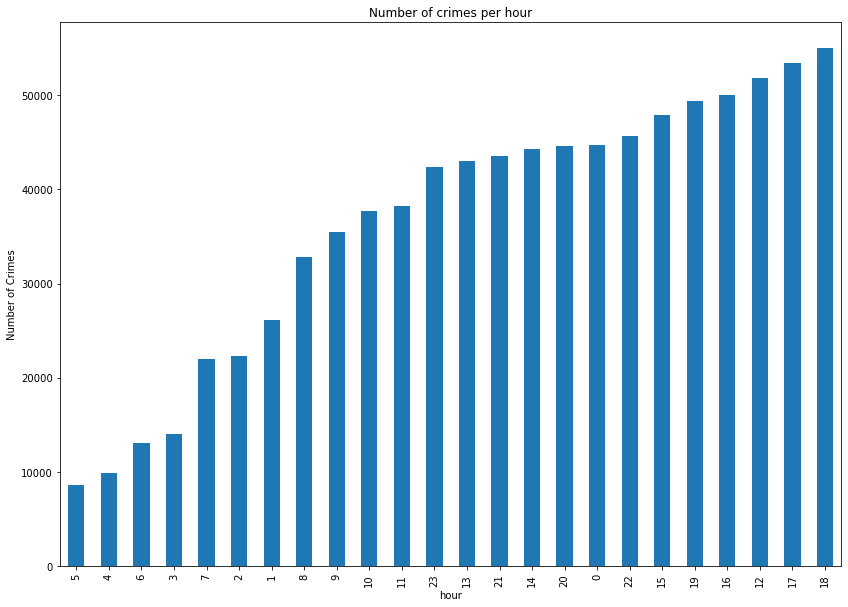

In [216]:
#Crimes per hour

plt.figure(3, figsize=(14,10))
plt.title('Number of crimes per hour')
plt.ylabel('Number of Crimes')
plt.xlabel('hour')


X_df.groupby([X_df['hour']]).size().sort_values(ascending=True).plot(kind='bar')

plt.show()

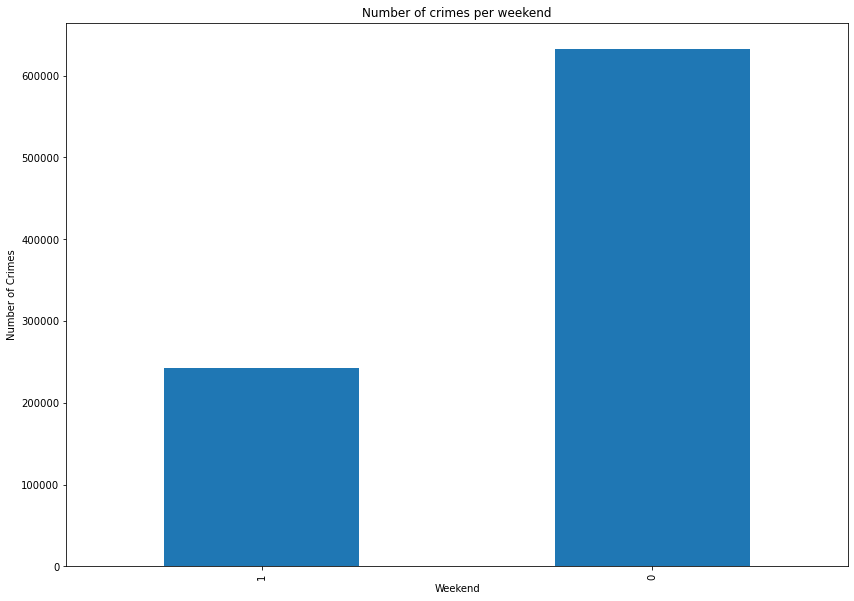

In [217]:
#Crimes per weekend

plt.figure(3, figsize=(14,10))
plt.title('Number of crimes per weekend')
plt.ylabel('Number of Crimes')
plt.xlabel('weekend')


X_df.groupby([X_df['Weekend']]).size().sort_values(ascending=True).plot(kind='bar')

plt.show()

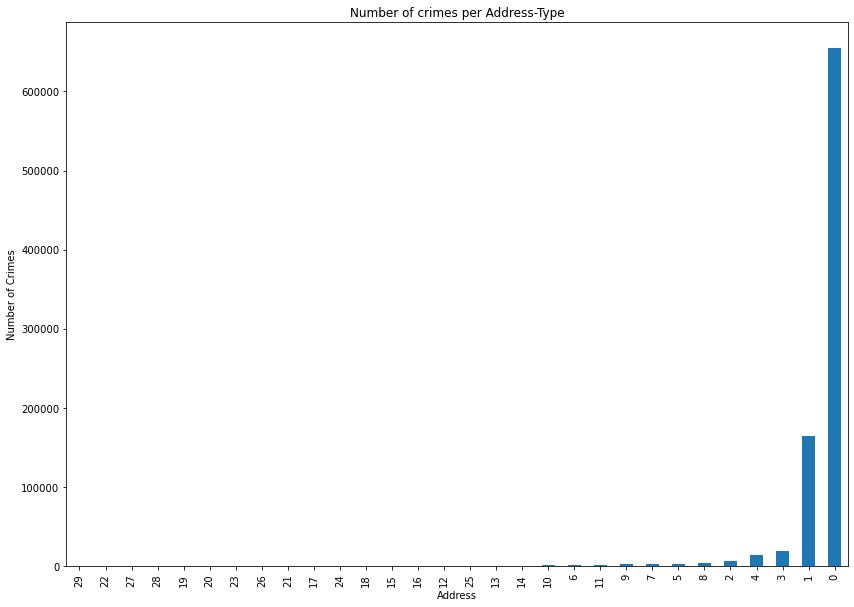

In [218]:
#Crimes per Address Type

plt.figure(3, figsize=(14,10))
plt.title('Number of crimes per Address-Type')
plt.ylabel('Number of Crimes')
plt.xlabel('Address-Type')


X_df.groupby([X_df['Address']]).size().sort_values(ascending=True).plot(kind='bar')

plt.show()

#### Preparing the models (normalization and splitting)
        

In [219]:
mean = X_df.mean(axis=0)
std = X_df.std(axis=0)
X_df = (X_df - mean) / std
#x_test = (x_test_origin - mean) / std

In [220]:
#Train- data split into train and test datasets
x_train, x_test, y_train, y_test = train_test_split(X_df, Y_df[0], train_size=0.8, random_state=0, stratify=Y_df[0])

print("training samples: ", x_train.shape[0])
print("test samples: ", x_test.shape[0])
print("sample dimension: ", x_train.shape[1])


training samples:  700527
test samples:  175132
sample dimension:  10


#### Classifier: Neural Network

In [186]:
#13 Input Layer; 1 Output Layer
from keras.models import Sequential
from keras.layers import Input, Flatten, Dense, Dropout

model = Sequential()
model.add(Input(shape=X_df.shape[1]))
model.add(Dense(60, activation='relu'))
model.add(Dropout(rate=0.3))
model.add(Dense(120, activation='relu'))
model.add(Dropout(rate=0.3))
model.add(Dense(39, activation='softmax'))

model.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_21 (Dense)            (None, 120)               1320      
                                                                 
 dropout_14 (Dropout)        (None, 120)               0         
                                                                 
 dense_22 (Dense)            (None, 60)                7260      
                                                                 
 dropout_15 (Dropout)        (None, 60)                0         
                                                                 
 dense_23 (Dense)            (None, 39)                2379      
                                                                 
Total params: 10,959
Trainable params: 10,959
Non-trainable params: 0
_________________________________________________________________


In [187]:
model.compile(loss="sparse_categorical_crossentropy", optimizer="adam", metrics=["accuracy"])

In [188]:
history = model.fit(
  x_train,
  y_train,
  batch_size=500,
  epochs=20,
  validation_split=.2,
)

Epoch 1/20
1121/1121 [==============================] - 4s 4ms/step - loss: 2.6966 - accuracy: 0.2055 - val_loss: 2.5991 - val_accuracy: 0.2225
Epoch 2/20
1121/1121 [==============================] - 4s 4ms/step - loss: 2.6095 - accuracy: 0.2221 - val_loss: 2.5610 - val_accuracy: 0.2366
Epoch 3/20
1121/1121 [==============================] - 4s 4ms/step - loss: 2.5865 - accuracy: 0.2290 - val_loss: 2.5465 - val_accuracy: 0.2403
Epoch 4/20
1121/1121 [==============================] - 4s 4ms/step - loss: 2.5749 - accuracy: 0.2324 - val_loss: 2.5374 - val_accuracy: 0.2425
Epoch 5/20
1121/1121 [==============================] - 4s 4ms/step - loss: 2.5667 - accuracy: 0.2340 - val_loss: 2.5311 - val_accuracy: 0.2445
Epoch 6/20
1121/1121 [==============================] - 5s 4ms/step - loss: 2.5604 - accuracy: 0.2355 - val_loss: 2.5259 - val_accuracy: 0.2452
Epoch 7/20
1121/1121 [==============================] - 5s 4ms/step - loss: 2.5559 - accuracy: 0.2361 - val_loss: 2.5213 - val_accuracy: